In [1]:
import cv2
import numpy as np

from scipy.signal import find_peaks, peak_widths
from scipy.integrate import simps

In [2]:
from typing import *
array = np.array

# step 1
def denoise(img: array, kernel: Tuple[int, int], area_thresh: int) -> array:
    # threshold and inverse
    _, thresh = cv2.threshold(img, 0, 0xff, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # morphology
    kernel = np.ones(kernel, np.uint8)
    thresh =  cv2.erode(thresh, kernel, iterations=1)

    # remove small blobs
    contours, _  = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if cv2.contourArea(c) < area_thresh]
    mask = np.zeros_like(thresh)
    for c in contours:
        mask = cv2.drawContours(mask, [c], 0, 0xff, -1)
    thresh[mask==0xff] = 0
    return thresh


# identify consecutive 0s in a 1-d array
def zero_runs(arr: array) -> List[List[int]]:
    iszero = np.concatenate(([0], np.equal(arr, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return [list(range(r[0], r[1])) for r in ranges]


# merge 0 peaks to corresponding adjacent peaks
# @todo: when have time, optimize this crappy code
def merge_zero_peaks(peaks: array, widths: array, ranges: List[List[int]]) -> Tuple[array, ...]:
    new_peaks, new_widhts = [], []

    i = 0
    while i < len(peaks):
        _size = 1
        _peak = peaks[i]
        _width = widths[i]
        exception = False 

        for r in ranges:
            if i in r:
                if len(r) > 1:
                    _size = len(r)
                    _peak = sum([peaks[j] for j in r]) / _size 
                    _width = sum([widths[j] for j in r])
                    break 

                else:
                    dist_left  = peaks[i] - peaks[i-1] if i>0 else 1e09
                    dist_right = peaks[i+1] - peaks[i] if i+1 < len(peaks) else 1e09

                    if dist_left < dist_right:
                        new_peaks[-1] = (new_peaks[-1] + peaks[i]) // 2
                        new_widhts[-1] += widths[i]
                        exception = True
                        break

                    else:
                        _size = 2
                        _peak = (peaks[i] + peaks[i+1]) // 2
                        _width = widths[i] + widths[i+1]
                        break

        i += _size
        if not exception:
            new_peaks.append(_peak)
            new_widhts.append(_width)

    return array(new_peaks).astype(int), array(new_widhts).astype(int)


# merge close peaks recursively to respect a total width threshold
def recursive_merge(peaks: array, widths: array, w_thresh: int) -> Tuple[List[int], List[int]]:
    # base case
    if widths.sum() <= w_thresh:
        _peak = int(peaks.mean())
        _width = widths.sum()
        return [_peak], [_width]
    
    # split according to max dist
    split_id = np.diff(peaks).argmax() + 1
    peaks1, widths1 = recursive_merge(peaks[:split_id], widths[:split_id], w_thresh)
    peaks2, widths2 = recursive_merge(peaks[split_id:], widths[split_id:], w_thresh)
    return peaks1 + peaks2, widths1 + widths2


def merge_close_peaks(peaks: array, widths: array, dist_thresh: int, stepsize: int=1) -> Tuple[array, ...]:
    new_peaks = peaks.tolist()
    new_widths = widths.tolist()

    # get indices of peaks that are closer than threshold
    close_ids = np.where(np.diff(peaks) < dist_thresh)[0]
    # split them into consecutive
    close_ids = np.split(close_ids, np.where(np.diff(close_ids) != stepsize)[0]+1)
    if not len(close_ids[0]):
        return peaks, widths
    close_ids = [np.append(ids, ids.max() + 1) for ids in close_ids]

    # replace with merged peaks
    offset = 0
    for ids in close_ids:
        ps, ws = recursive_merge(peaks[ids], widths[ids],  widths.max())
        new_peaks[ids[0]-offset : ids[-1]+1-offset] = ps
        new_widths[ids[0]-offset : ids[-1]+1-offset] = ws
        offset += len(peaks[ids]) - len(ps) 

    return array(new_peaks).astype(int), array(new_widths).astype(int)

In [3]:
kernel = (2,2)
area_thresh = 100
count_thresh = 5
dist_thresh = 10
kappa = 0.7

In [4]:
line = cv2.imread('/home/ggtz/Pictures/Selection_367.png', 0)
line.shape

(67, 657)

In [5]:
clean = denoise(line, kernel, area_thresh)

vertical_count = np.where(clean > 0, 1, 0).sum(axis=0)

binary_count = np.where(vertical_count > count_thresh, 1, 0)

In [6]:
def segments(ps, ws, flags):
    ps0 = [p for i, p in enumerate(ps) if flags[i]==0]
    ps1 = [p for i, p in enumerate(ps) if flags[i]==1]

    spans = [(int(p-w/2), int(p+w/2)) for p, w in zip(ps, ws)]
    segm = [(s[1] + spans[i+1][0]) // 2 for i, s in enumerate(spans[:-1])]
    segm1 = [s for s in segm if np.count_nonzero(clean[:, s][:-1] < clean[:, s][1:]) < 2]
    segm2 = [s for s in segm if s not in segm1]
    
    return ps0, ps1, segm1, segm2

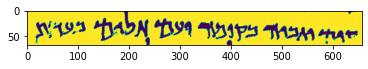

In [18]:
import matplotlib.pyplot as plt
plt.imshow(line)
plt.show()

def visualize(clean, vertical, binary, peaks0, peaks1, segments_fil, segments_cut):
    fig1, (ax2, ax3) = plt.subplots(2, sharex=True, figsize=(25,25));
    ax2.imshow(clean);
    ax2.vlines(segments_fil, 0, 60, color="C5", linestyle='solid')
    ax2.vlines(segments_cut, 0, 60, color="C5", linestyle='dotted')
    ax3.grid(True);
    ax3.plot(vertical, 'b-');
    ax3.plot(binary * 20, 'y--');
    ax3.hlines(count_thresh, 0, len(vertical_count), color="C1");
    ax3.plot(peaks0, [20] * len(peaks0), 'rx');
    ax3.plot(peaks1, [20] * len(peaks1), 'gx');
    ax3.vlines(segments_fil, 0, 40, color="C5", linestyle='solid')
    ax3.vlines(segments_cut, 0, 40, color="C5", linestyle='dotted')
    plt.show()

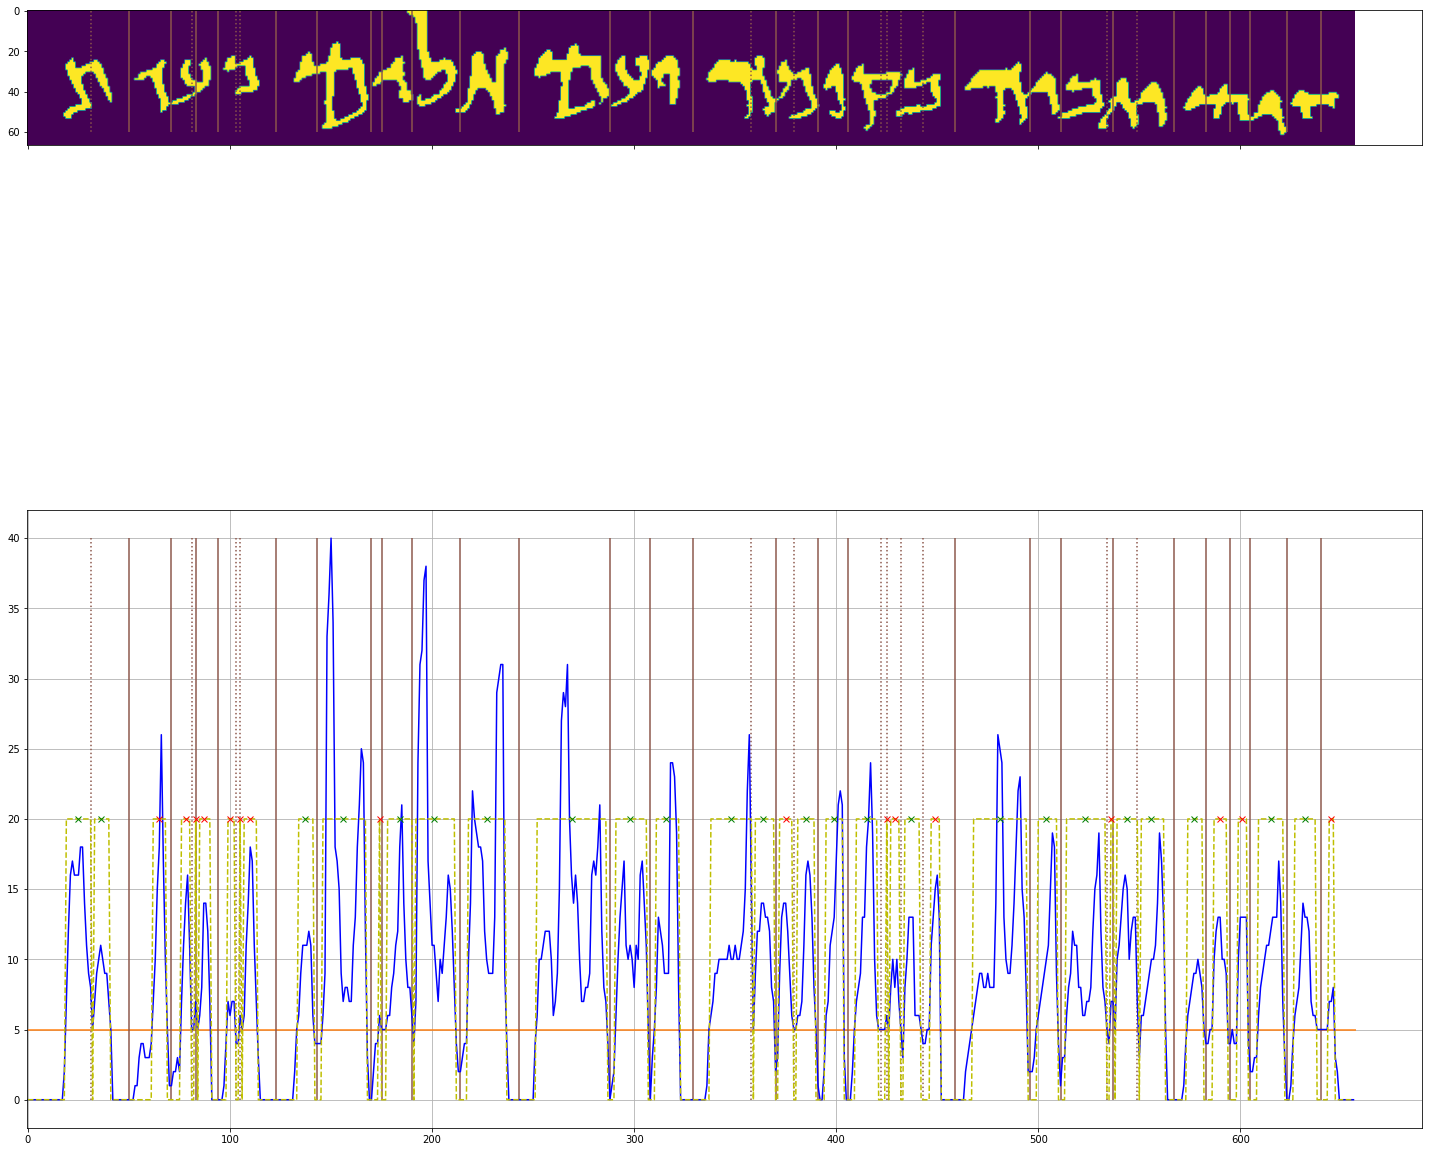

In [8]:
peaks, _ = find_peaks(binary_count)
widths = peak_widths(binary_count, peaks)[0]
w_thresh = widths.mean() * kappa
flags = np.where(widths > w_thresh, 1, 0)

peaks0, peaks1, segments_fil, segments_cut = segments(peaks, widths, flags)
    
visualize(clean, vertical_count, binary_count, peaks0, peaks1, segments_fil, segments_cut)

In [9]:
w_thresh

7.227499999999999

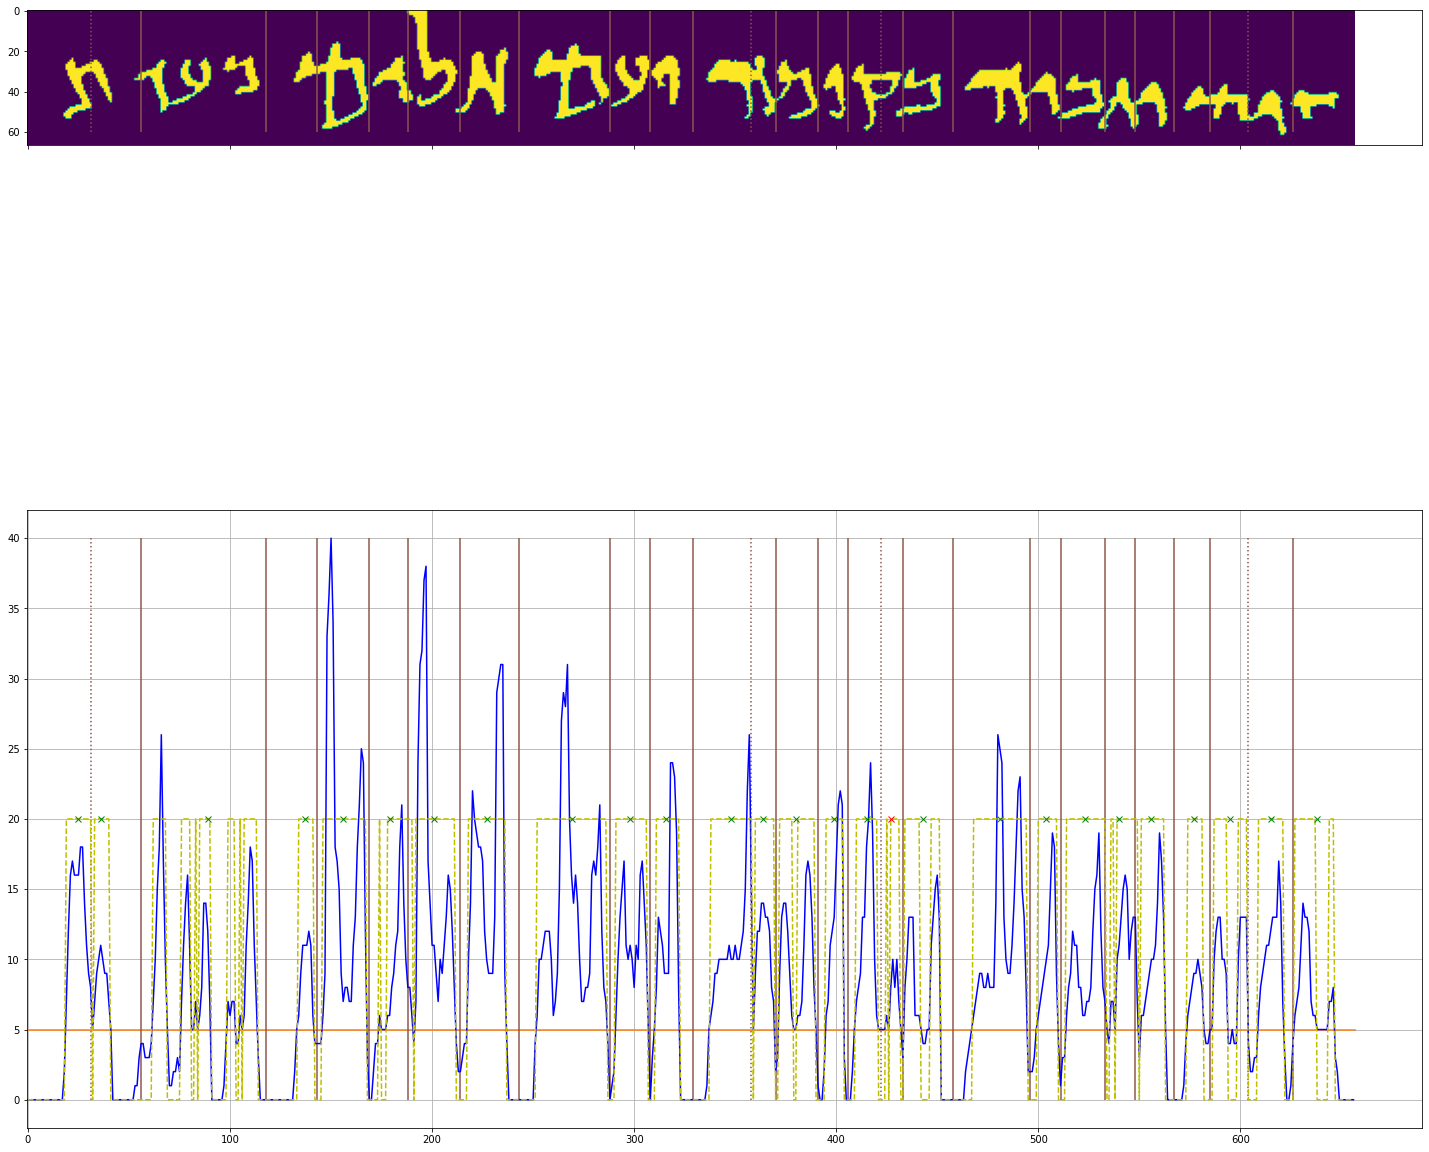

In [10]:
peaks_adapted, widths_adapted = merge_zero_peaks(peaks, widths, zero_runs(flags))
flags_adapted = np.where(widths_adapted > w_thresh, 1, 0)

peaks0, peaks1, segments_fil, segments_cut  = segments(peaks_adapted, widths_adapted, flags_adapted)

visualize(clean, vertical_count, binary_count, peaks0, peaks1, segments_fil, segments_cut)

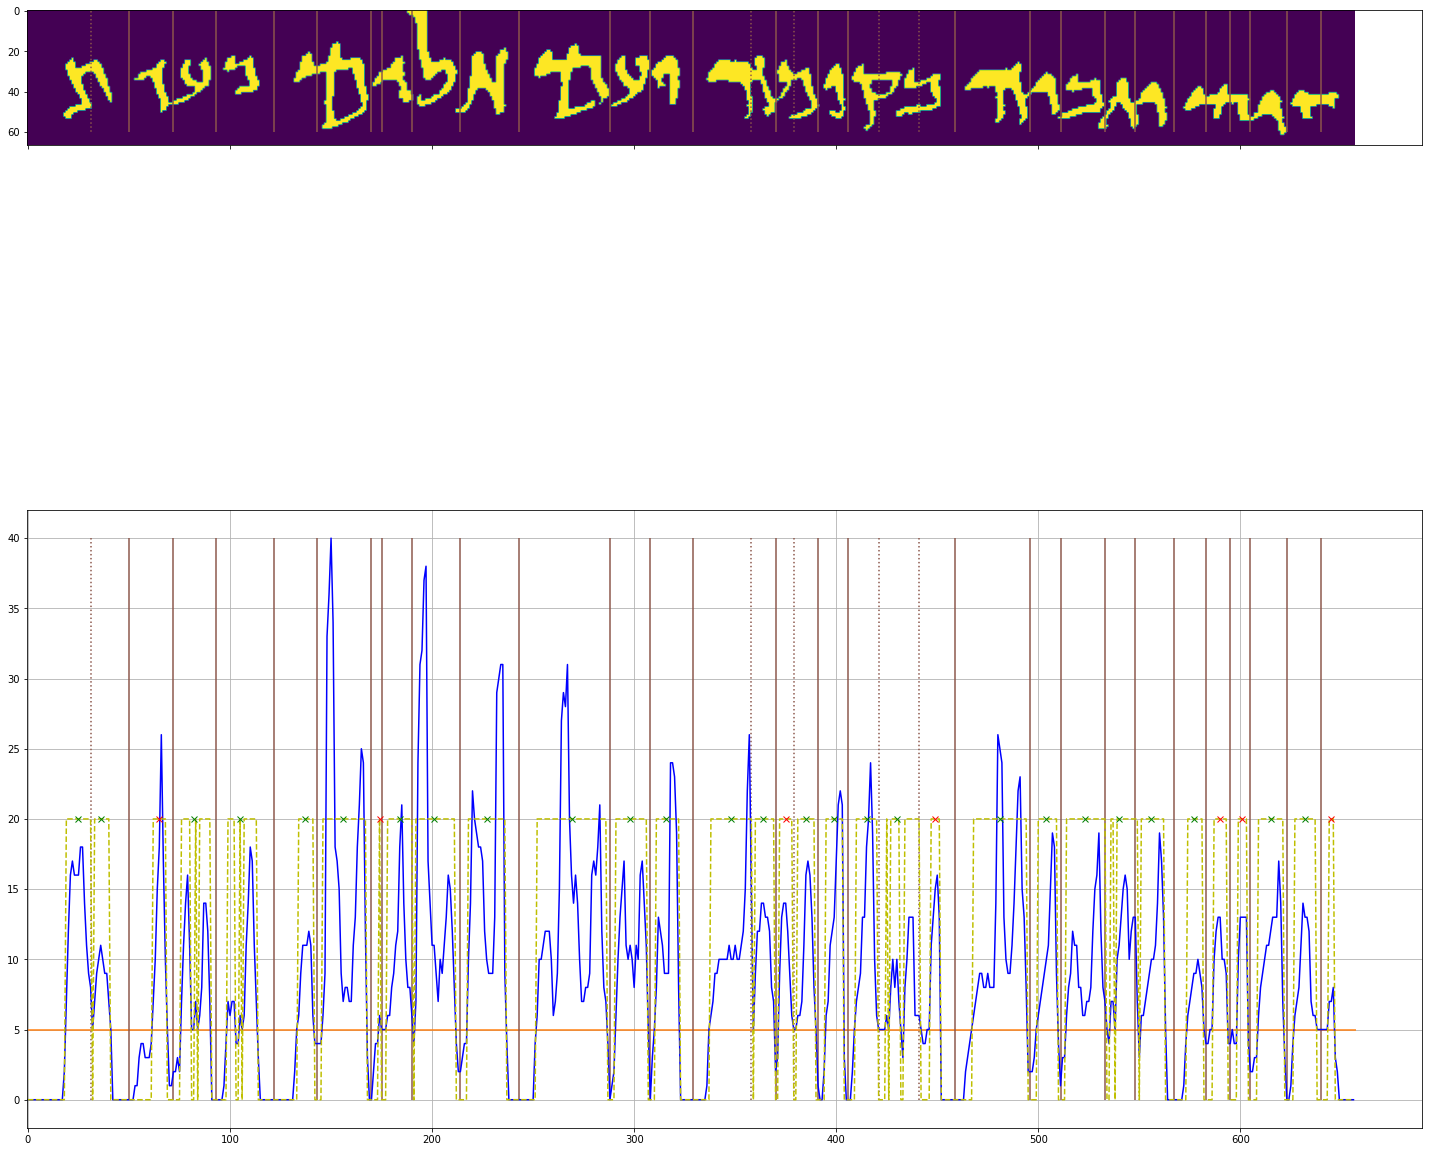

In [11]:
peaks_merged, widths_merged = merge_close_peaks(peaks, widths, dist_thresh)
flags_merged = np.where(widths_merged > w_thresh, 1, 0)

peaks0, peaks1, segments_fil, segments_cut = segments(peaks_merged, widths_merged, flags_merged)

visualize(clean, vertical_count, binary_count, peaks0, peaks1, segments_fil, segments_cut)

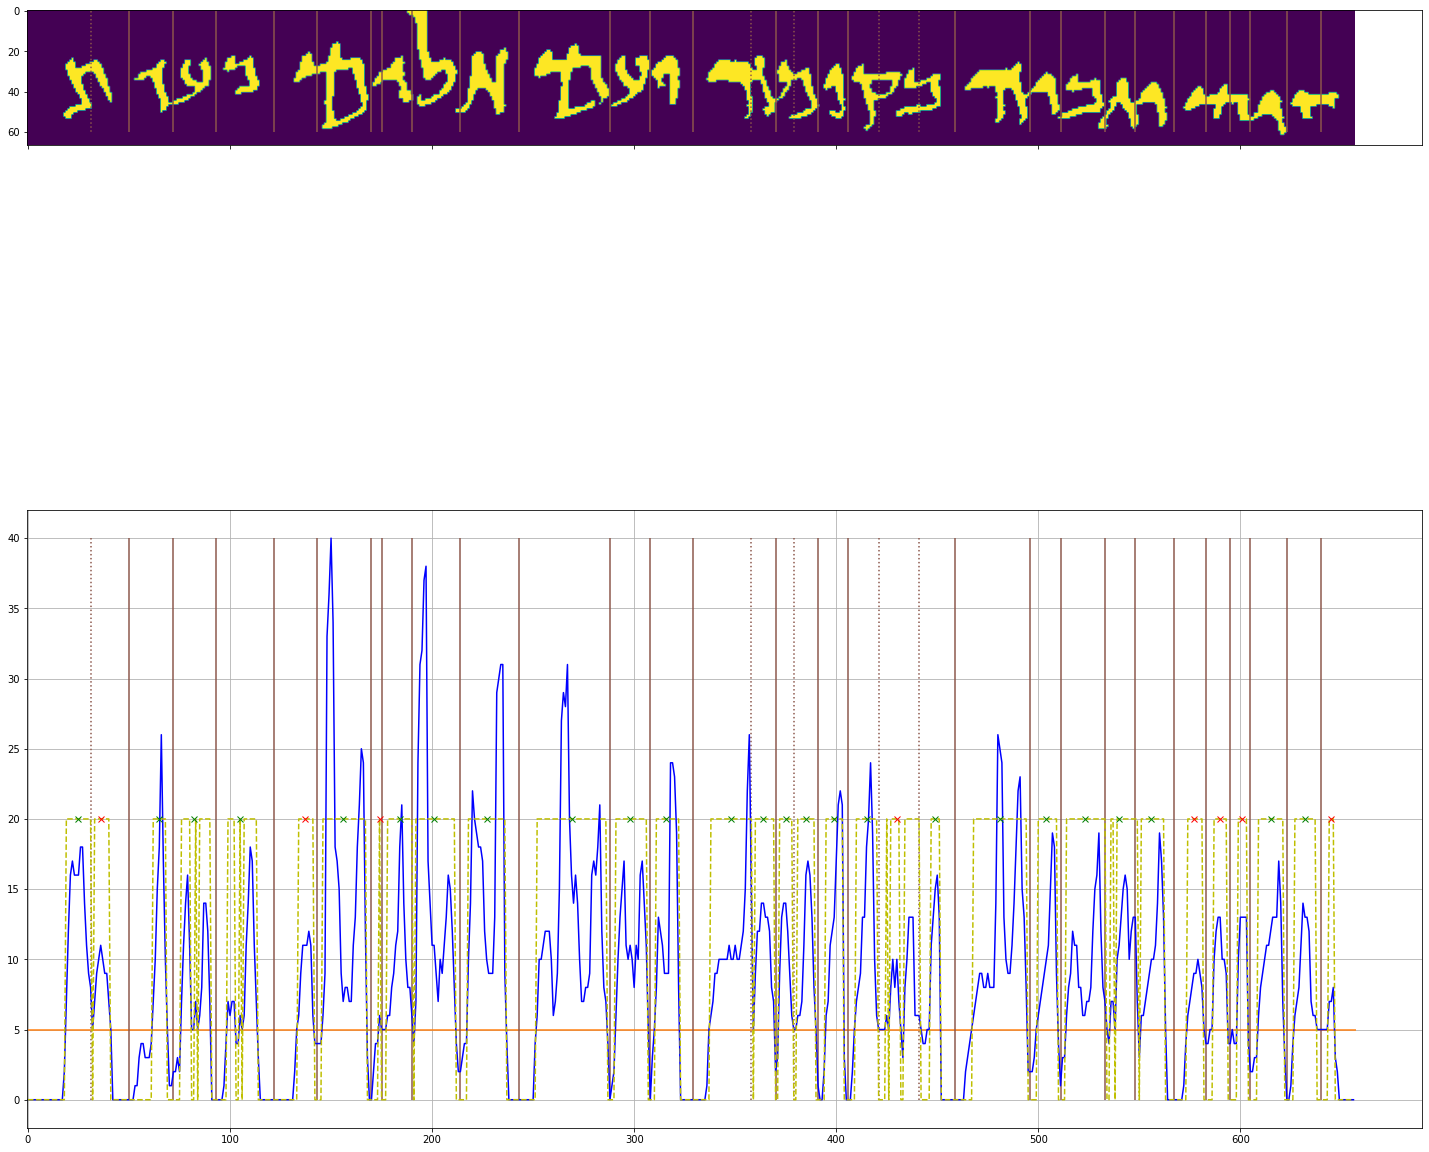

In [14]:
# or alternatively, use also height for flagging

heights = array([vertical_count[p-w//2 : p+w//2+1].max() for p, w in zip(peaks_merged, widths_merged)])

flags_merged_h = np.where(heights > kappa * heights.mean(), 1, 0)

#flags_merged_h = np.bitwise_and(flags_h, flags_merged)

peaks0, peaks1, segments_fil, segments_cut = segments(peaks_merged, widths_merged, flags_merged_h)

visualize(clean, vertical_count, binary_count, peaks0, peaks1, segments_fil, segments_cut)

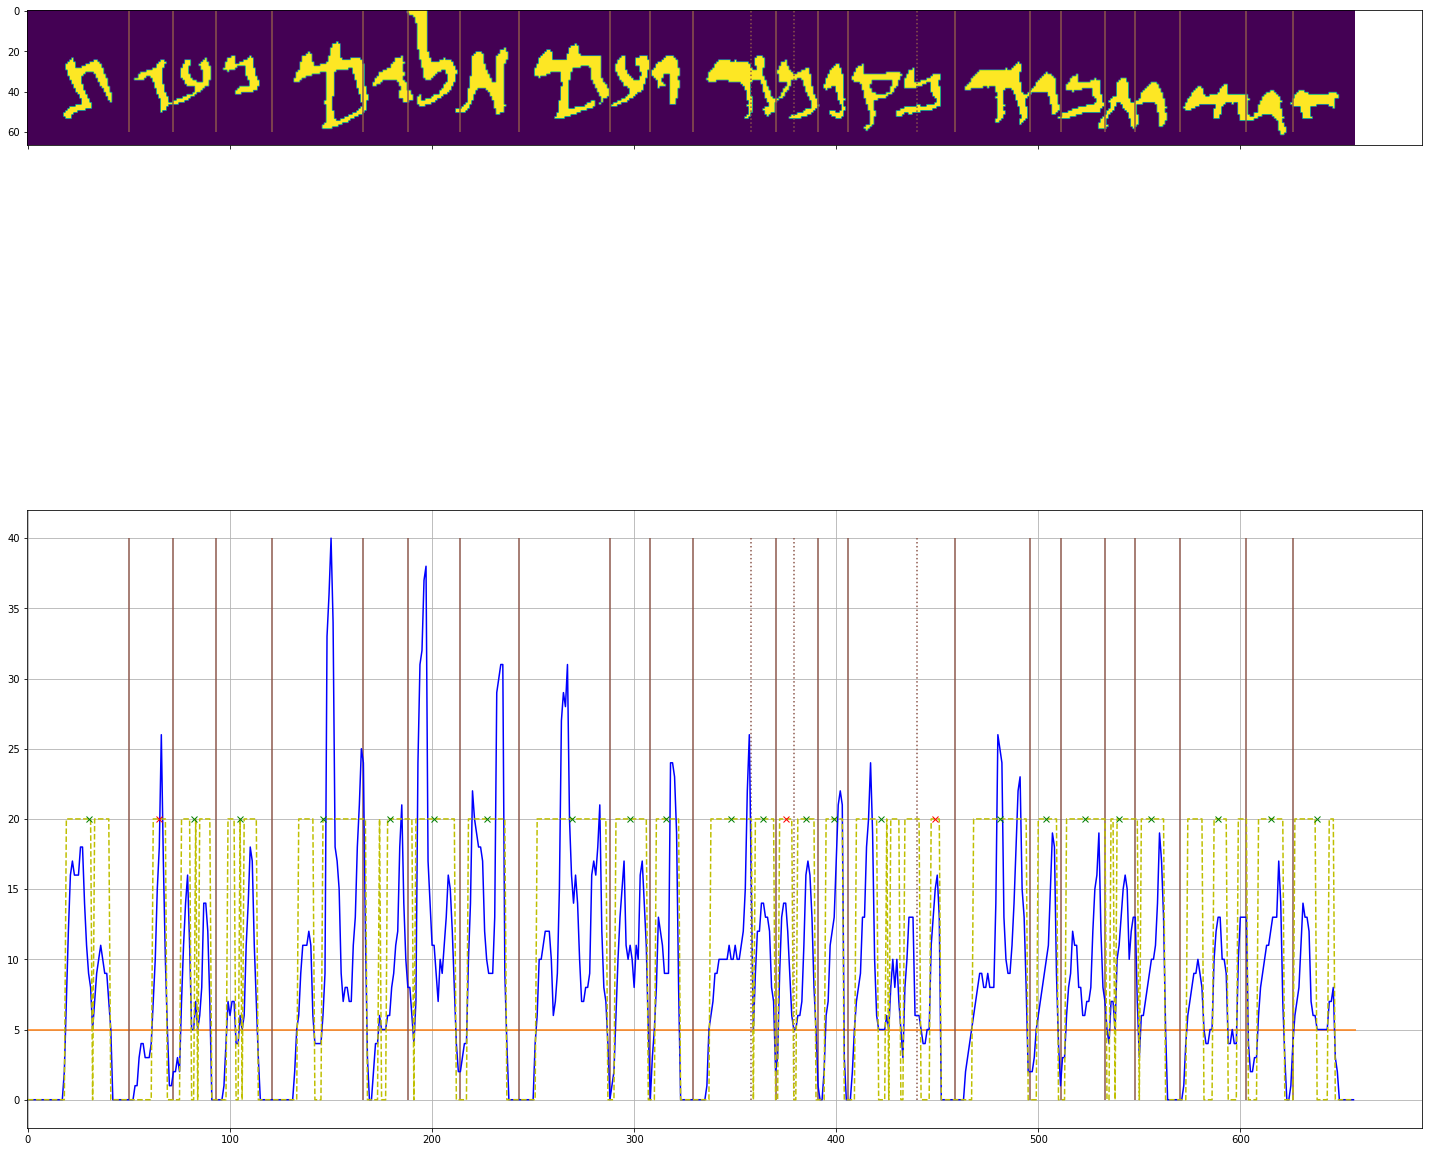

In [15]:
peaks_merged_adapted, widths_merged_adapted = merge_zero_peaks(peaks_merged, widths_merged, zero_runs(flags_merged_h))
flags_merged_adapted = np.where(widths_merged_adapted > w_thresh, 1, 0)

peaks0, peaks1, segments_fil, segments_cut = segments(peaks_merged_adapted, widths_merged_adapted, flags_merged_adapted)

visualize(clean, vertical_count, binary_count, peaks0, peaks1, segments_fil, segments_cut)